# A CNN classifying the cifar10 data with and without Dropout

Many Thanks to Lars Bosshard and Michael Prummer who adpated large parts of the code from Python to R as part of a DL coaching with Beate.

**Goal:**  The goal is to set up a CNN that is appropriate to predict for each image of the test set in Cifar10 data a multinomial probability distribution that assignes to each of the 10 possible classes a probability. You will train the CNN from scratch. You will investigate the impact of dropout during training. You will see that dropout during training is a very easy way to prevent overfitting and even to improve the accuracy!

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Dataset:** In this notebook you work with the Cifar10 dataset. The data is from the Canadian Institute For Advanced Research.  You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). The images (32x32x3) are quite small and therefore  it's not always very easy to recoginse which of the ten classes is on the iamge, even as a human. 

**Content:**
* Load the Cifar10 dataset
* Plot example images
* Normalize the images
* Define and fit a Convolutional neural network with dropout layers in the fully connected part
Define and fit a Convolutional neural network without any dropout layers
* Compare the test prediction performance (loss and accuracy of the two models)

Original python version 
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_02.ipynb)


# Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [6]:
#For Kaggel Notebooks no installation needed

# Imports

In the next cell, we load all the required libraries and functions. 

In [7]:
library(RCurl)
library(kableExtra)
library(reshape2)
library(keras)
library(tensorflow)
library(tidyverse)
library(graphics)
tf$version$VERSION #2.3.0

[1] "2.6.5"

# Load, plot and normalize the data

The cifar10 data are shipped together with keras.

In [8]:
cifar10 <- dataset_cifar10()
x_train <- cifar10$train$x
y_train <- cifar10$train$y
x_test <- cifar10$test$x
y_test <- cifar10$test$y

Let's have a look on some images.


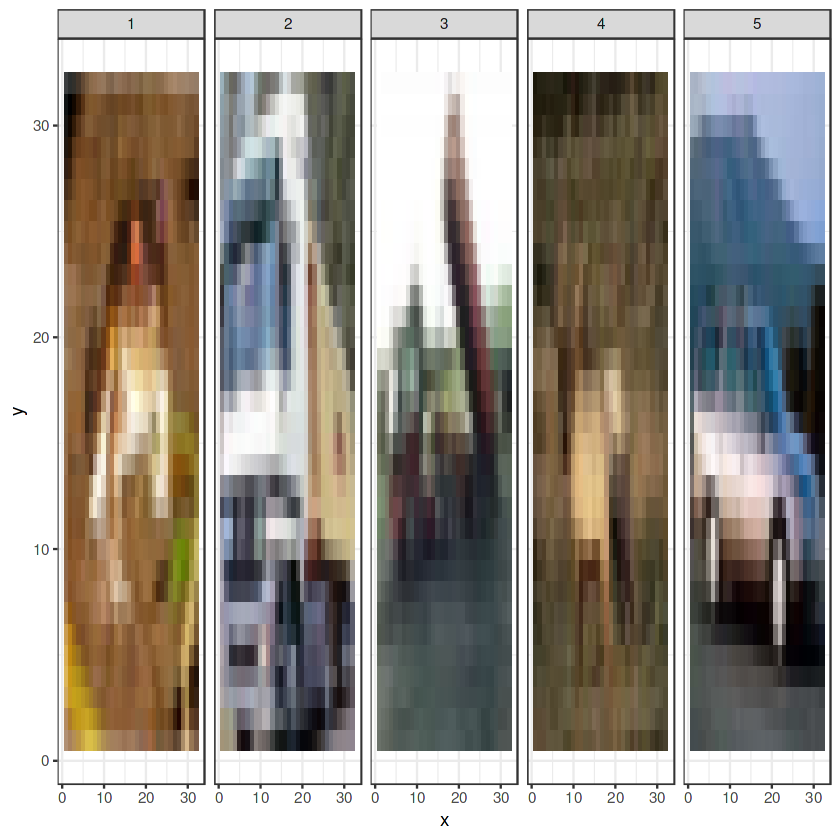

In [9]:
dd <- expand.grid(1:32,1:32)
colnames(dd) <- c("x","y")
dd <- data.frame(x=rep(dd$x,5),y=rep(dd$y,5))
dd$r <- NA
dd$g <- NA
dd$b <- NA
dd$pic <- rep(1:5,each=32*32)
idx <- 32:1
idx2 <- c("r","g","b")

for (k in 1:5){
  for (j in 1:3){
    for (i in 1:32){
      dd[dd$y==idx[i] & dd$pic==k,idx2[j]] <- x_train[k,i,,j]
    }
  }
}

# normalize the images to values between 0 and 1
dd$r <- dd$r/255
dd$g <- dd$g/255
dd$b <- dd$b/255
ggplot(data=dd, aes(x=x, y=y, fill=rgb(r,g,b))) +
  geom_tile() +
  scale_fill_identity() +
  theme_bw()+
  facet_wrap(~pic,ncol=5)

Prepare the labels as one-hot-encoded.


In [10]:
to_one_hot <- function(labels, dimension = 10) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}
X_train <- x_train/255
X_val <- x_test/255
#X_test <- x_test/255

Y_train <- to_one_hot(y_train)
Y_val <- to_one_hot(y_test)

dim(X_train)
dim(X_val)
dim(Y_train)
dim(Y_val)


[1] 50000    32    32     3

[1] 10000    32    32     3

[1] 50000    10

[1] 10000    10

# Define and fit a CNN with dropout layers

In the next few cells you will define and train a CNN to classify the images into the 10 classes.




In [11]:
batch_size = 128
nb_classes = 10
img_rows = 32
img_cols = 32
kernel_size = c(3, 3)
input_shape = c(img_rows, img_cols, 3)
pool_size = c(2, 2)

model <- keras_model_sequential() %>% 
  # convolutional part of the CNN
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu",input_shape = input_shape) %>% 
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%

  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_flatten() %>% 

  #fully connected part of the CNN
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = nb_classes, activation = "softmax")

summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_3 (Conv2D)                   (None, 32, 32, 16)              448         
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 32, 32, 16)              2320        
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 16, 16, 16)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 16, 16, 32)              4640        
________________________________________________________________________________
conv2d (Conv2D)                     (None, 16, 16, 32)              9248        
________________________________________________________________________________
max_pool

In [12]:
# compile model and intitialize weights
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

## Training of the model

`geom_smooth()` using formula 'y ~ x'



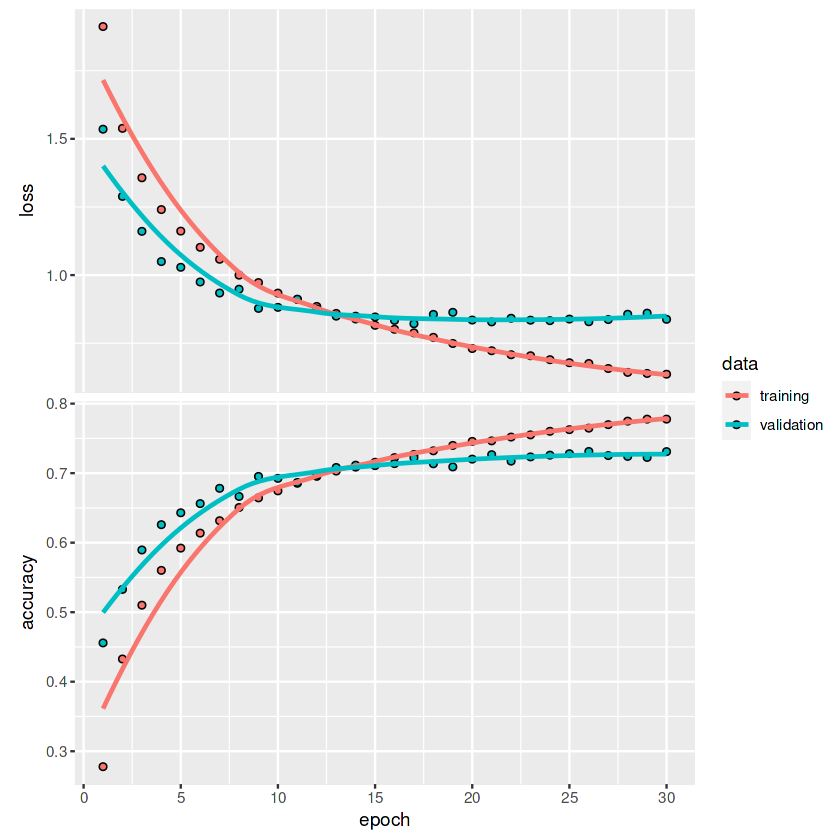

In [13]:
# train the model (can take 2-3 minuntes)
history <- model %>% fit(
  X_train, Y_train, 
  epochs = 30, batch_size=batch_size,
  verbose=0, validation_data = list(X_val, Y_val))
plot(history)


In [14]:
results <- model %>% evaluate(X_val, Y_val, verbose=0)
results

loss  accuracy 
0.8376711 0.7310000

# Additional Task

Repeat the training and exerpiment without the dropout layer.

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*...*

In [15]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.2    stringr_1.4.1    dplyr_1.0.10     purrr_0.3.4     
 [5] readr_2.1.2      tidyr_1.2.1      tibble_3.1.8     ggplot2_3.3.6   
 [9] tidyverse_1.3.2  tensorflow_2.9.0 keras_2.6.0      reshape2_1.4.4  
[13] kableExtra_1.3.4 RCurl_1.98-1.